In this notebook, we transform raw datasets to parquet format to enable faster loading speed during training and evaluation.

The raw format of released datasets is as follows:
```python
# train set
/train/real/...
/train/fake/...
/train/masks/...
# valid set
/valid/real/...
/valid/fake/...
/valid/masks/...
```

In [1]:
import os
from datasets import Dataset, DatasetDict
from datasets import Features, Image
from typing import List


def load_images_from_dir(directory: str) -> List[str]:
    return [
        os.path.join(directory, fname)
        for fname in os.listdir(directory)
        if fname.endswith(("jpg", "jpeg", "png"))
    ]


def create_split(root_dir: str, split: str) -> Dataset:
    fake_dir = os.path.join(root_dir, split, "fake")
    masks_dir = os.path.join(root_dir, split, "masks")
    real_dir = os.path.join(root_dir, split, "real")

    fake_images = load_images_from_dir(fake_dir)
    mask_images = load_images_from_dir(masks_dir)
    real_images = load_images_from_dir(real_dir)

    assert len(fake_images) == len(mask_images)

    return Dataset.from_dict(
        {
            "image": fake_images + real_images,
            "mask": mask_images + [None] * len(real_images),
        },
        features=Features(
            {"image": Image(), "mask": Image()}
        ),
    )


def create_dataset(root_dir: str) -> DatasetDict:
    train_dataset = create_split(root_dir, split="train")
    valid_dataset = create_split(root_dir, split="valid")

    return DatasetDict({"train": train_dataset, "valid": valid_dataset})

root_dir = "/gemini/space/lye/track1"

/root/miniconda3/envs/loupe/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We merge `real/` and `fake/` into `images` column for simplity. A image is real if there is no corresponding mask.

In [ ]:
dataset = create_dataset(root_dir)
dataset

Then save processed datasets to parquet.

In [ ]:
trainset = dataset["train"]
validset = dataset["valid"]
trainset.to_parquet(os.path.join(root_dir, "train.parquet"))
validset.to_parquet(os.path.join(root_dir, "valid.parquet"))

Load from processed datasets to do whatever you want.

In [59]:
import os
from datasets import load_dataset

validset = load_dataset(
    "parquet", data_files=os.path.join("/gemini/space/jyc/track1", "train.parquet")
)
validset

Generating train split: 954931 examples [00:01, 618486.49 examples/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 954931
    })
})

In [60]:
subset = validset["train"].shuffle(seed=42).select(range(10000))
sum([subset[i]["mask"] is not None for i in range(len(subset))])

8387

In [2]:

import hydra
hydra.initialize(config_path="configs")

/tmp/ipykernel_3967810/989117794.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")


hydra.initialize()

In [3]:
import sys
sys.path.insert(0, "./src")

from models.loupe.configuration_loupe import LoupeConfig
from models.loupe.modeling_loupe import LoupeModel
from models.loupe.image_precessing_loupe  import LoupeImageProcessor
from lit_model import LitModel


[2025-05-10 20:14:32,039] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/lib

In [35]:

cfg = hydra.compose(config_name="base.yaml", overrides=["stage=seg"])
# cfg.model.checkpoint_path = "/gemini/code/loupe/checkpoints/seg/model.safetensors"
loupe_config = LoupeConfig(stage=cfg.stage.name, **cfg.model)
model = LoupeModel(loupe_config)
model = LitModel(cfg, model)
processor = LoupeImageProcessor(loupe_config)

2025-05-10 20:30:11.371 | INFO     | models.loupe.modeling_loupe:__init__:595 - Loading backbone from /gemini/code/loupe/pretrained_weights/pe/PE-Core-L14-336.pt


Missing keys for loading vision encoder: []
Unexpected keys for loading vision encoder: ['proj']


In [36]:
image, mask = validset["train"][0]["image"], validset["train"][0]["mask"]
image2, mask2 = validset["train"][1]["image"], validset["train"][1]["mask"]

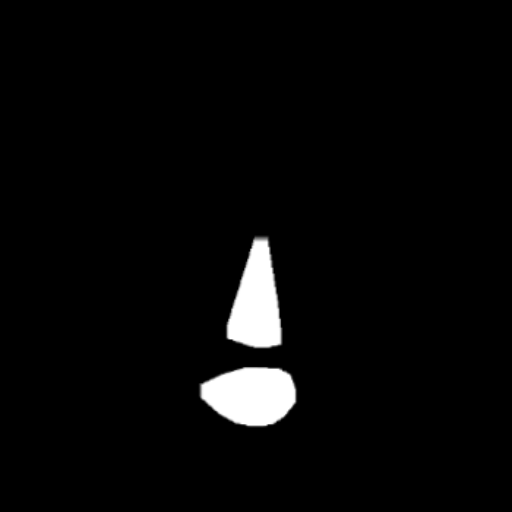

In [37]:
mask

In [38]:
import torch


bin_mask = processor.convert_to_binary_masks(mask)
# reduce labels
processed_mask = torch.where(bin_mask == 0, 255, bin_mask - 1).to(
    dtype=torch.uint8
)

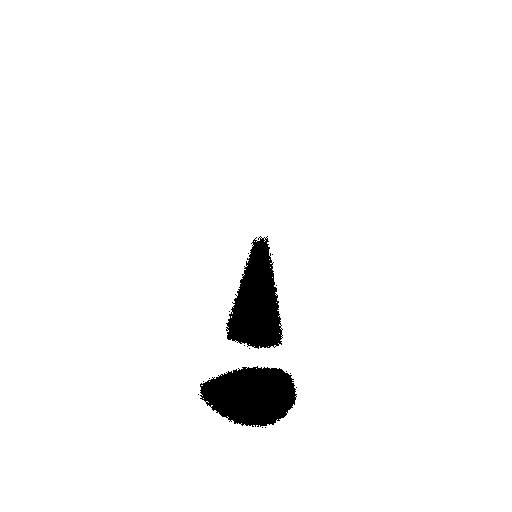

In [39]:
Image.fromarray((processed_mask.cpu()).numpy())

In [46]:
import torch

inputs = processor(image, mask, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
segmentation = processor.post_process_segmentation(
    outputs["class_queries_logits"], outputs["masks_queries_logits"], target_sizes=[(512, 512)]
)

In [45]:
Image.fromarray((segmentation[0].cpu()).numpy())
torch.any(segmentation[0] == 0).item()

False

In [42]:
from src.metric import Metric
import torch
from torchvision import transforms
metric = Metric()
metric.compute_iou(segmentation, [processed_mask])

np.float64(0.0)

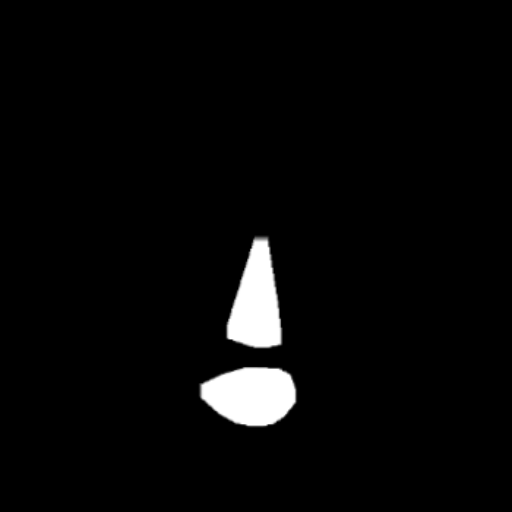

In [54]:
mask

In [58]:
import numpy as np
import evaluate

mean_iou = evaluate.load("/gemini/code/loupe/src/metric/mean_iou.py")
predicted = np.array([[0, 0, 0], [0, 0, 0], [0, 0, 0]])
ground_truth = np.array([[255, 255, 255], [255, 0, 255], [255, 255, 255]])
results = mean_iou.compute(predictions=[predicted], references=[ground_truth], num_labels=2, ignore_index=254)
results

{'mean_iou': np.float64(0.1111111111111111),
 'mean_accuracy': np.float64(1.0),
 'overall_accuracy': np.float64(1.0),
 'per_category_iou': array([0.11111111,        nan]),
 'per_category_accuracy': array([ 1., nan])}

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Your provided Poly1FocalLoss (binary classification with soft labels)
class Poly1FocalLoss(nn.Module):
    def __init__(self, epsilon=1.0, alpha=0.9, gamma=2.0):
        super(Poly1FocalLoss, self).__init__()
        assert 0 <= alpha <= 1, "alpha should be between 0 and 1."
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = "mean"

    def forward(self, logits, labels, **kwargs):
        p = torch.sigmoid(logits)
        assert p.shape == labels.shape, f"Expected logits and labels to have the same shape, got {logits.shape} and {labels.shape}."

        ce_loss = F.binary_cross_entropy_with_logits(
            input=logits, target=labels, reduction="none", **kwargs
        )

        pt = labels * p + (1 - labels) * (1 - p)
        FL = ce_loss * ((1 - pt) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * labels + (1 - self.alpha) * (1 - labels)
            FL = alpha_t * FL

        poly1 = FL + self.epsilon * torch.pow(1 - pt, self.gamma + 1)

        if self.reduction == "mean":
            poly1 = poly1.mean()
        elif self.reduction == "sum":
            poly1 = poly1.sum()

        return poly1

# Equivalent version for binary soft-label loss (matching the structure)
class Poly1FocalLossAlternative(nn.Module):
    def __init__(self, epsilon=1.0, alpha=0.9, gamma=2.0, reduction="mean"):
        super().__init__()
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        pt = targets * probs + (1 - targets) * (1 - probs)
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        focal = ce_loss * ((1 - pt) ** self.gamma)
        if self.alpha >= 0:
            alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            focal = focal * alpha_factor
        poly1 = focal + self.epsilon * (1 - pt) ** (self.gamma + 1)

        if self.reduction == 'mean':
            return poly1.mean()
        elif self.reduction == 'sum':
            return poly1.sum()
        return poly1

# Generate test data
torch.manual_seed(42)
logits = torch.randn(10, 5)  # 10 samples, 5 "patches"
labels = torch.rand(10, 5)   # soft labels in [0, 1]

# Initialize both loss functions
loss_fn_ref = Poly1FocalLoss(epsilon=1.0, alpha=0.9, gamma=2.0)
loss_fn_alt = Poly1FocalLossAlternative(epsilon=1.0, alpha=0.9, gamma=2.0)

# Compute and compare losses
loss_ref = loss_fn_ref(logits, labels)
loss_alt = loss_fn_alt(logits, labels)

loss_ref, loss_alt, torch.allclose(loss_ref, loss_alt, rtol=1e-5)


(tensor(0.2434), tensor(0.2434), True)

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Poly1FocalLossMultiClassSoft(nn.Module):
    def __init__(self, epsilon=1.0, gamma=2.0, reduction='mean'):
        super().__init__()
        self.epsilon = epsilon
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        probs = torch.softmax(logits, dim=1)
        ce_loss = -torch.sum(targets * torch.log(probs + 1e-8), dim=1)
        pt = torch.sum(targets * probs, dim=1)
        loss = (1 - pt) ** self.gamma * ce_loss + self.epsilon * (1 - pt) ** (self.gamma + 1)

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Example usage
torch.manual_seed(0)
logits = torch.randn(6, 4)
targets = torch.softmax(torch.randn(6, 4), dim=1)

loss_fn = Poly1FocalLossMultiClassSoft()
loss = loss_fn(logits, targets)
print("Loss:", loss.item())


Loss: 1.3658934831619263
